# Importing Libraries

In [1]:
!pip install wget -q
!pip install gdown -q
!pip install opencv-python -q

In [11]:
import numpy as np

from kaggle.api.kaggle_api_extended import KaggleApi

import cv2

import os

import wget

import gdown

import pandas as pd

import matplotlib.pyplot as plt

import math

from tqdm import tqdm

import glob

import shutil

import random

import ast

import xml.etree.ElementTree as ET

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download the working data

In [7]:
ROOT = os.getcwd()

# comment this line if you are using kaggle
ROOT = os.path.dirname(ROOT)

utils_dir = os.path.join(ROOT, 'utils')

In [9]:
# Comment this cell line if you are running locally

os.makedirs(utils_dir, exist_ok=True)  # Create the data directory if it doesn't exist

# Google Drive folder ID
FOLDER_ID = "1nTsEHmKnQrjv6yLfp3FyzOqsFU9xhOc9"

# gdown syntax for downloading folders
gdown.download_folder(f"https://drive.google.com/drive/folders/{FOLDER_ID}", output=utils_dir)

folder_file_list = os.listdir(utils_dir)
print("Utils folder list: \n", folder_file_list)

Retrieving folder contents


Processing file 17LAbe_EM-5aLW1B50SHF_A35gus1wz1r utils.py


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=17LAbe_EM-5aLW1B50SHF_A35gus1wz1r
From (redirected): https://drive.google.com/uc?id=17LAbe_EM-5aLW1B50SHF_A35gus1wz1r&confirm=t&uuid=09d6794d-f175-4061-be96-d66d2193e507
To: D:\Projects\Gate-Access-Controller\utils\utils.py
100%|██████████| 2.85k/2.85k [00:00<00:00, 2.85MB/s]

Utils folder list: 
 ['util.py', 'utils.py']



Download completed


# Importing util functions

In [23]:
from utils.utils import *

## display the functions inside the utils file

In [24]:

def display_functions(file_path):
    with open(file_path, "r") as f:
        file_contents = f.read()
    
    # Parse the file's contents using ast
    parsed_code = ast.parse(file_contents)
    
    # Loop through the parsed nodes and find functions
    for node in parsed_code.body:
        if isinstance(node, ast.FunctionDef):
            print(f"Function name: {node.name}")
            print(f"Arguments: {[arg.arg for arg in node.args.args]}")
            print(f"Line number: {node.lineno}\n")

# Replace it with the path to your .py file
file_path = utils_dir + "/utils.py"
display_functions(file_path)


Function name: show_images
Arguments: ['images', 'titles']
Line number: 30

Function name: show_3d_image
Arguments: ['img', 'title']
Line number: 50

Function name: show_3d_image_filtering_in_freq
Arguments: ['img', 'f']
Line number: 75

Function name: showHist
Arguments: ['img']
Line number: 87



# Preprocessing

In [20]:
# Paths for data set and its folder
# NOTE: the annotation directory contains the location of the plate in the image
# this will be implemented from scratch, and we will compare our results with the actual result of the dataset

# comment the following lines if you are using kaggle
#-------------------------------------------------------------
dataset_dir = os.path.join(ROOT, 'data','car-plate-detection') 
if not os.path.exists(dataset_dir):
    # Authenticate
    api = KaggleApi()
    api.authenticate()
    
    # Download the dataset
    api.dataset_download_files('andrewmvd/car-plate-detection', path=dataset_dir, unzip=True)
#-------------------------------------------------------------

# DATA_DIR = '/kaggle/input/car-plate-detection' # Kaggle
DATA_DIR = dataset_dir # Local
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
ANNOTATIONS_DIR = os.path.join(DATA_DIR, 'annotations')
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 200

# sorts filenames alphabetically (lexicographically)
image_files = sorted(os.listdir(IMAGES_DIR))

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection


In [25]:
# Function to load an image and its corresponding annotation
def load_image_and_annotation(image_name, 
                              image_dir, 
                              annotation_dir,
                              load_annotation = False):
    # 1- get image path 
    # 2- read image 
    # 3- convert to RGB for display
    # When using cv2.imread(), the image is loaded in BGR order, not RGB.
    # so we need to convert it to RGB to display it correctly
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    if not load_annotation: return image

    # get the file extension from the image path
    extension = image_path.split('.')[1]

    print(f'file extension: {extension}')

    # Load corresponding XML annotation
    annotation_path = os.path.join(annotation_dir, image_name.replace(f'.{extension}', '.xml'))
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Get bounding box coordinates from the XML for the plate location
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    return image

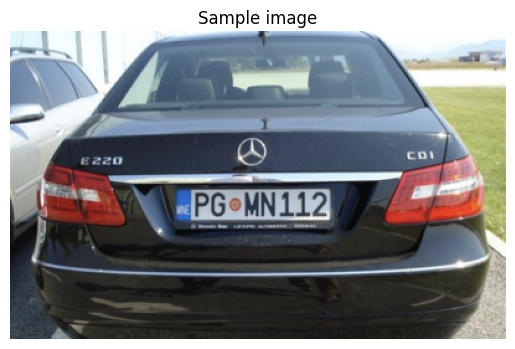

In [26]:
sample_image_name = image_files[1]
sample_image = load_image_and_annotation(sample_image_name, image_dir = IMAGES_DIR , annotation_dir = ANNOTATIONS_DIR)

show_images([sample_image],['Sample image'])

## Convert to GrayScale

In [27]:
def convert_to_gray(image):
    height, width, channels = image.shape
    gray_image = image
    if channels == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif channels == 4:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    else:
        print("Unkown color system the image will remain unchanged")

    return gray_image

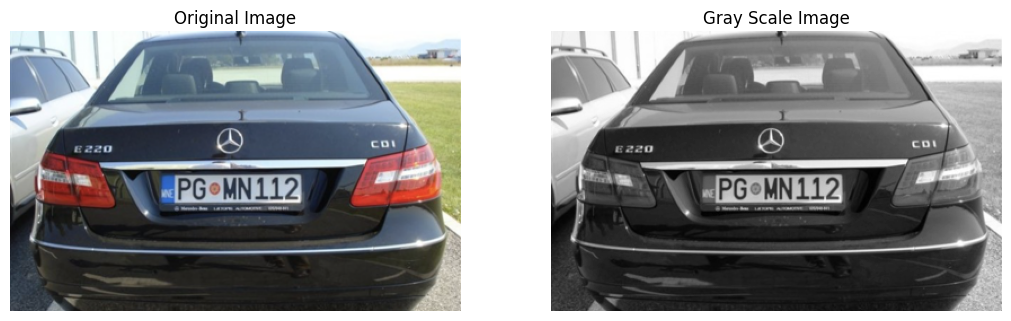

In [28]:
gray_image  = convert_to_gray(sample_image)

show_images([sample_image,gray_image],['Original Image' , 'Gray Scale Image'])

## Resize image

In [29]:
# The input image must be gray
# cv2.INTER_AREA is best for downscaling the image
def resize_with_aspect_ratio(gray_image, 
                             width = None, 
                             height = None, 
                             keep_aspect_ratio = False , 
                             interpolation = cv2.INTER_AREA):
    # Get the original width and height
    original_height,original_width = gray_image.shape
    # Set the original value to original dimensions

    if width is None and height is None: return gray_image 

    if width is None: width = original_width
    if height is None: height = original_height    

    if not keep_aspect_ratio: return cv2.resize(gray_image, (width, height), interpolation=interpolation)
        
    if width is not None:
        scaling_factor = width / original_width
    else:
        scaling_factor = height / original_height

    new_size = (int(original_width * scaling_factor), int(original_height * scaling_factor))
    
    resized_image = cv2.resize(gray_image, new_size, interpolation=interpolation)
    
    return resized_image    
    

### Get the average width and height of the dataset

In [30]:
total_width = 0
total_height = 0
num_images = len(image_files)

for image_file in  tqdm(image_files, desc="Processing images", unit=" image"):
    
    image_path = os.path.join(IMAGES_DIR, image_file)
    
    image = cv2.imread(image_path)
    
    if image is not None:
        height, width, _ = image.shape
        total_width += width
        total_height += height

# Calculate average width and height
average_width = total_width / num_images
average_height = total_height / num_images

print(f"Average Width: {average_width:.2f}")
print(f"Average Height: {average_height:.2f}")

Processing images: 100%|██████████| 433/433 [00:05<00:00, 83.70 image/s]

Average Width: 425.11
Average Height: 292.14


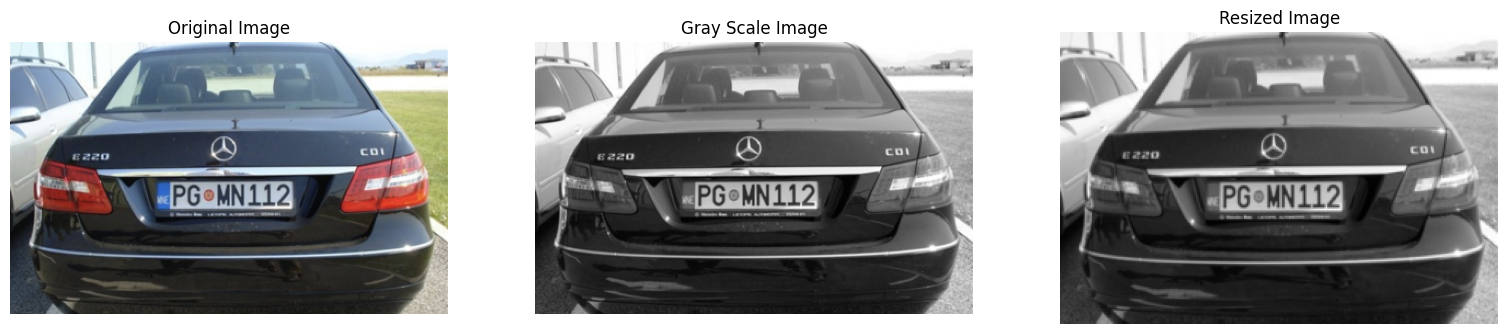

In [31]:
resized_image  = resize_with_aspect_ratio(gray_image, width = IMAGE_WIDTH, height = IMAGE_HEIGHT)
show_images([sample_image,gray_image,resized_image],['Original Image' , 'Gray Scale Image','Resized Image'])

## Convert to binary

In [32]:
# Apply adaptive thresholding
# cv2.adaptiveThreshold(): This function applies adaptive thresholding where the threshold value 
# is calculated based on the local neighborhood of each pixel. 
# It is particularly useful when the image has different lighting across different regions.

# 255 (Max Value): This is the maximum value that will be assigned to pixels 
# that exceed the dynamically calculated threshold in each region. 

# cv2.ADAPTIVE_THRESH_MEAN_C: The threshold value is the mean of the local neighborhood minus a constant C.
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C: The threshold value is the weighted sum of the local neighborhood minus a constant C.

# block size of a local region
# must be odd 
def convert_to_binary(image,block_size = 31,constant = 2):
    binary_image_adaptive = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, constant
    )
    return binary_image_adaptive
    

binary_image_adaptive = convert_to_binary(resized_image)

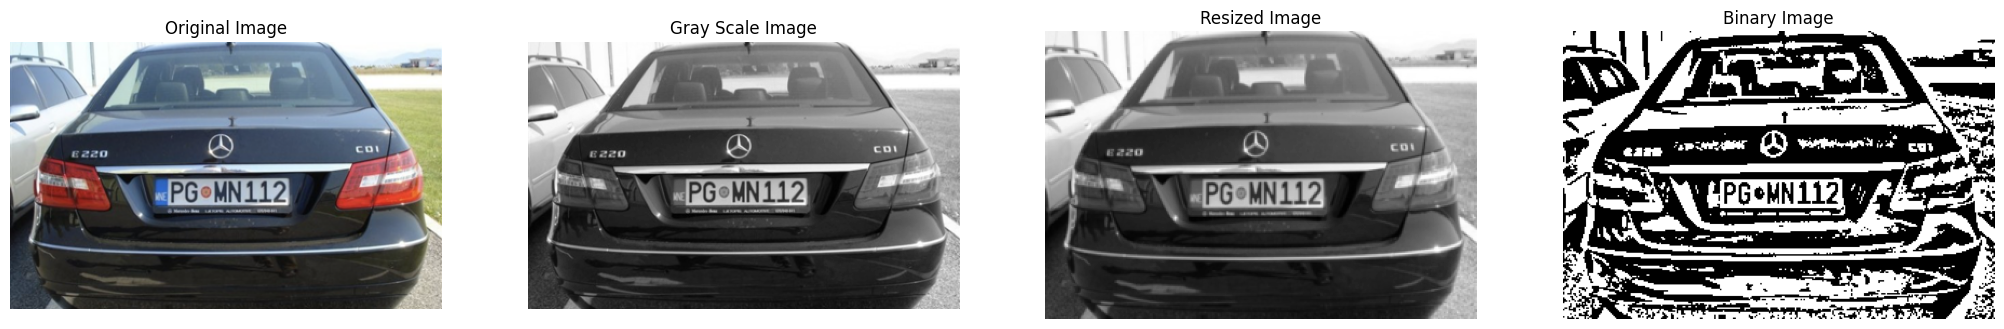

In [33]:
show_images([sample_image,gray_image,resized_image,binary_image_adaptive],
            ['Original Image' , 'Gray Scale Image','Resized Image','Binary Image'])

## Compining operations

In [34]:
def image_preprocessing(image_name, image_dir, annotation_dir,
                        resized_width = 300, resized_height = 200, 
                        keep_aspect_ratio = False,
                        resize_interpolation = cv2.INTER_AREA,
                        adaptive_threshold_block_size = 31,
                        adaptive_threshold_constant = 2,
                        load_annotation = False):
    # load image
    original_image = load_image_and_annotation(image_name,
                                               image_dir,
                                               annotation_dir,
                                               load_annotation)
    # convert to gray scale
    gray_scale_image = convert_to_gray(original_image)
    # resize image
    resized_image  = resize_with_aspect_ratio(gray_scale_image, 
                                              width = resized_width, 
                                              height = resized_height,
                                              keep_aspect_ratio = keep_aspect_ratio,
                                              interpolation = resize_interpolation)
    # convert to binary using adaptive thresholding
    binary_image_adaptive = convert_to_binary(resized_image,
                                              block_size = adaptive_threshold_block_size,
                                              constant = adaptive_threshold_constant)
    # display the results
    show_images([original_image,gray_scale_image,resized_image,binary_image_adaptive],
            ['Original Image' , 'Gray Scale Image','Resized Image','Binary Image'])
    

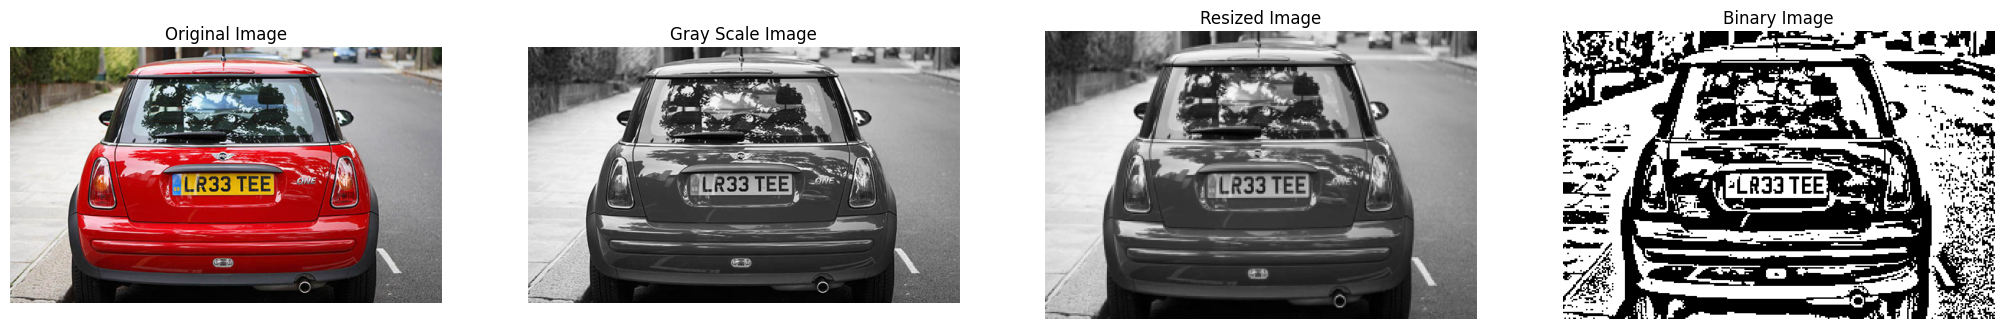

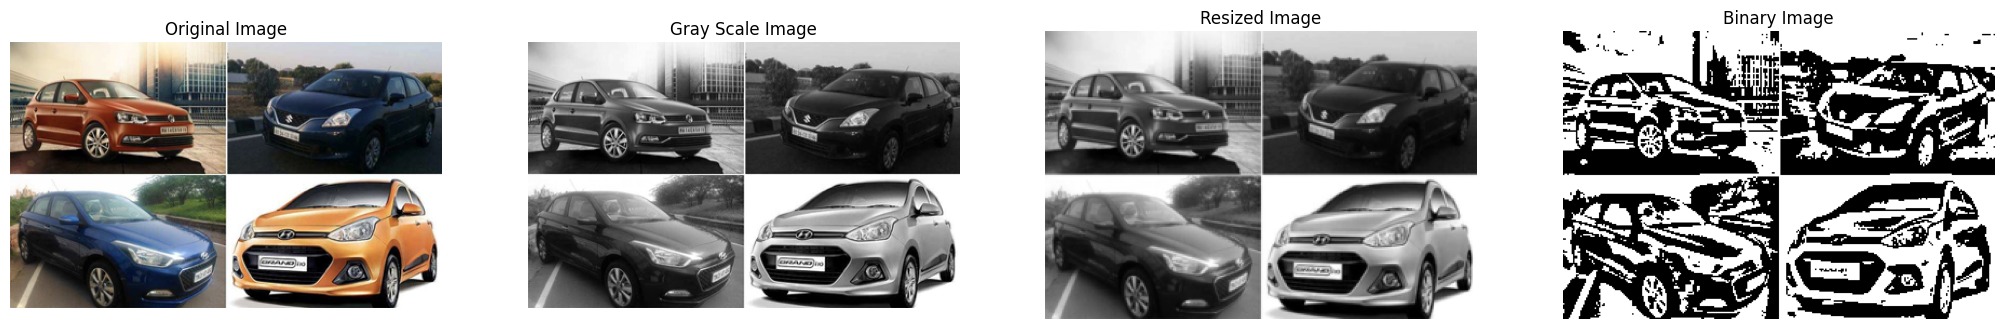

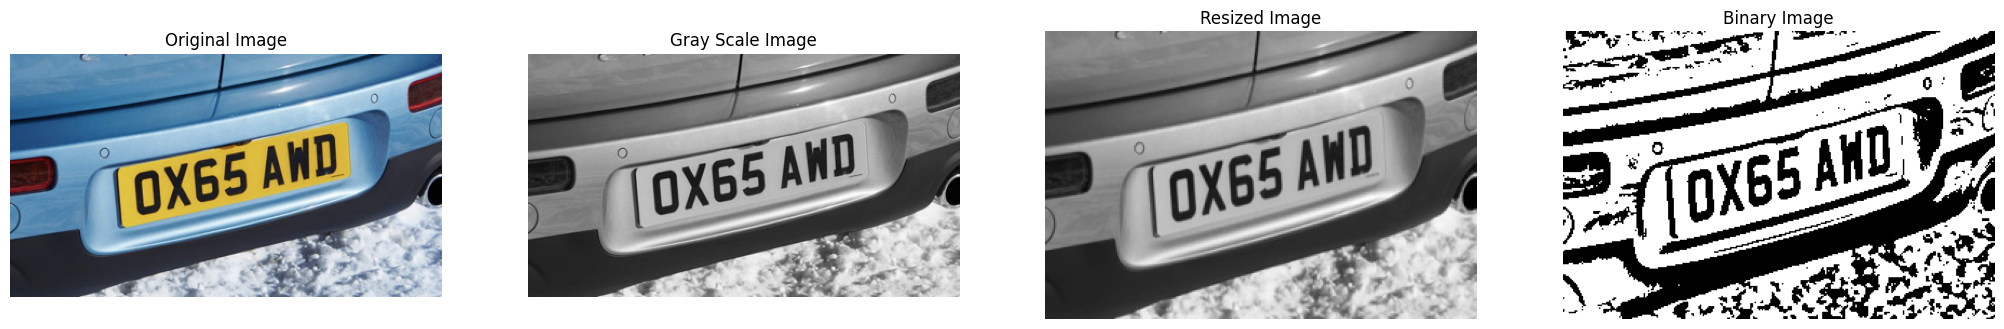

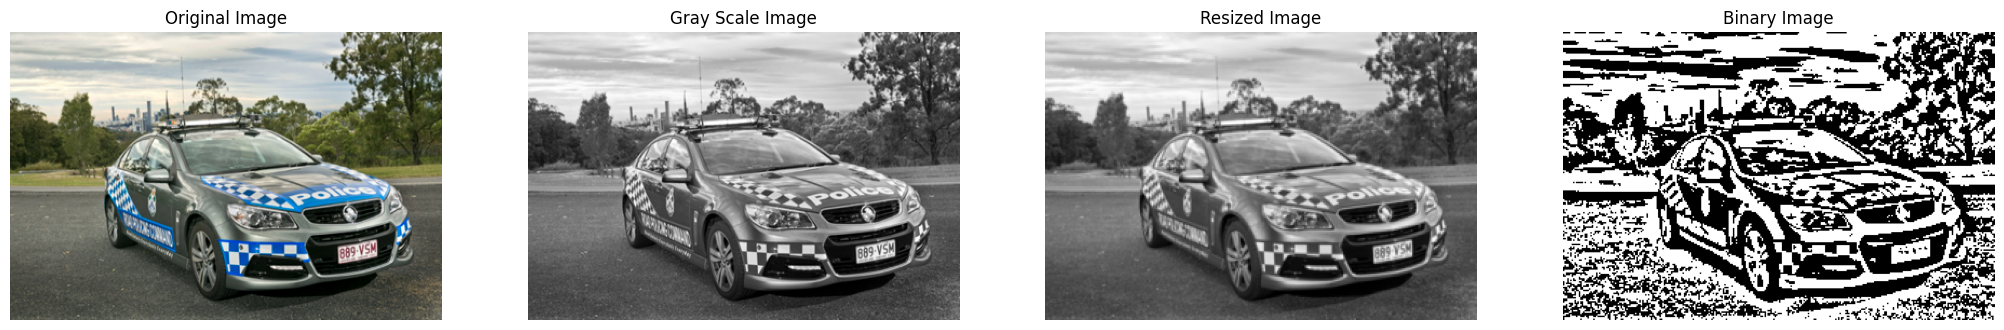

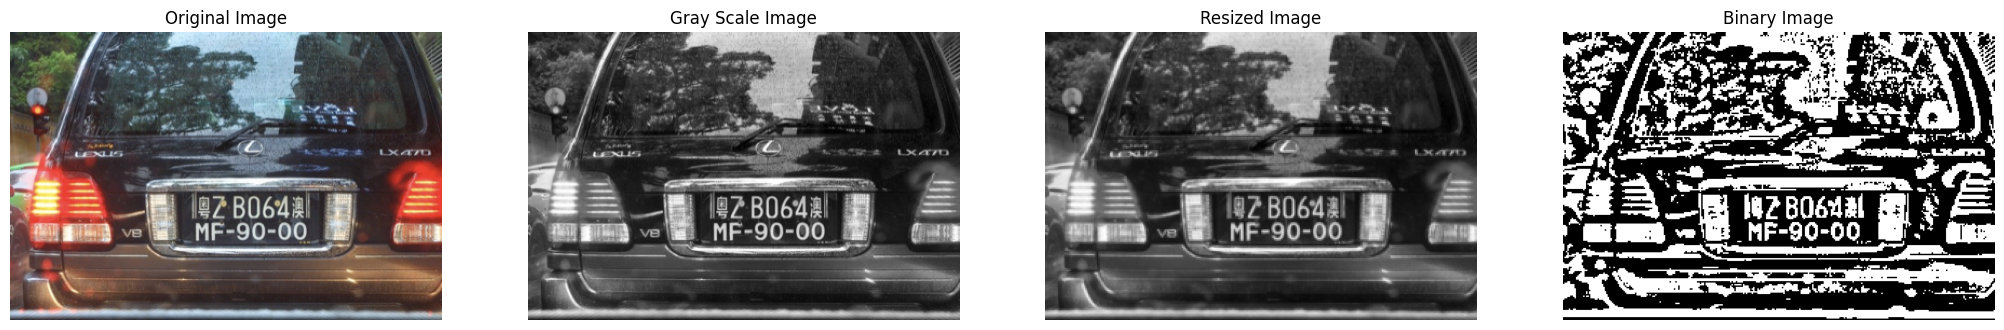

In [35]:
def preprocess_random_images(num_of_tests = 5):
    for i in range(num_of_tests):
        random_number = random.randint(0, len(image_files) - 1)
        image_preprocessing(image_name = image_files[random_number],
                            image_dir = IMAGES_DIR,
                            annotation_dir = ANNOTATIONS_DIR,
                            adaptive_threshold_block_size = 31,
                            resized_width = IMAGE_WIDTH,
                            resized_height = IMAGE_HEIGHT)    

preprocess_random_images()